In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math
import random
%load_ext autoreload
%autoreload 2

# Toy example with variational inference for data generation
$x$ - input/output variable <br>
$z$ - hidden variable <br>
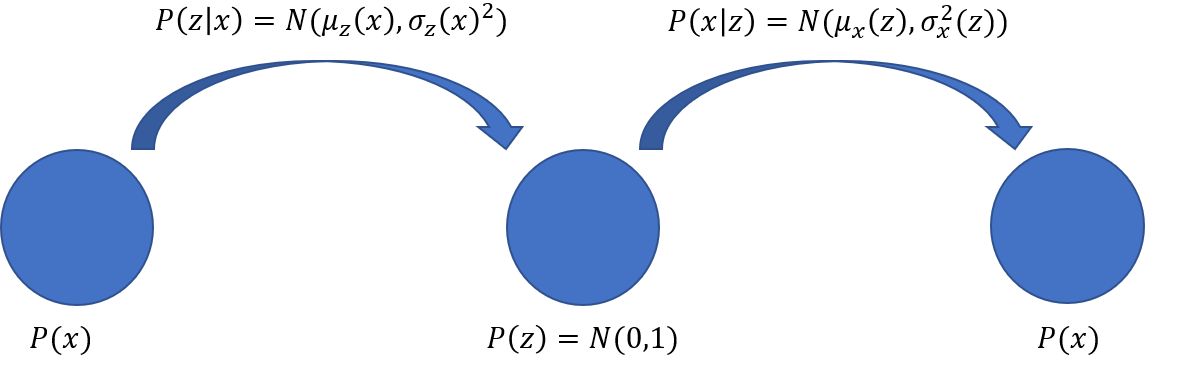
We want prior of hidden variable $P(z)$ to be described by probability density of standard normal: 
$$P(z)=\mathcal{N}(0,1) \text{ - "prior"}$$
There are two mappings of interest, which are also Gaussian: <br>
$$P(z|x)=\mathcal{N}(\mu_z(x),\sigma_z^2(x)) \text{ - "encoder"}$$
$$P(x|z)=\mathcal{N}(\mu_x(z),\sigma_x^2(z)) \text{ - "decoder"}$$

Marginal probabilities of hidden and input variables are linked by law of total probability:
$$P(z) = \int P(z|x) P(x) dx$$

# Analytically tractable set of parameters
$$P(z) = \mathcal{N}(0,1) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}z^2} $$
$$ x = e^{\hat{x}}, \hat{x} \sim \mathcal{N}(0,\sigma_{\hat{x}}^2 = \frac{1}{2})$$
$$ z = \log x + \epsilon, \epsilon \sim \mathcal{N}(0, \sigma_{\epsilon}^2 = \frac{1}{2})$$
Note that inverse transform is not gaussian:
$$ x = e^z \cdot e^{-\epsilon}$$
$$ E(x|z) = e^{1/4} e^z $$
$$ Var(x|z) = (e-e^{1/2})e^z $$

### Generation of the data

In [8]:
Npoints = 100000
sigma_x = np.sqrt(1/2)
sigma_z = np.sqrt(1/2)

# torch works with float32
x = np.exp(sigma_x * np.random.randn(Npoints))
z = np.log(x) + sigma_z * np.random.randn(Npoints)

x_torch = torch.as_tensor(x.astype('float32')).reshape((-1,1))

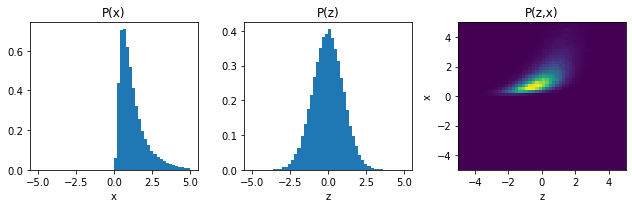

In [98]:
def plot_histograms(x, z, nbins=50, xy_range = 3):
    fig = plt.figure(figsize=(9,3))
    plt.subplot(131)
    plt.hist(x, bins=nbins, density = True, range=(-xy_range,xy_range));
    plt.xlabel('x')
    plt.title('P(x)')
    plt.subplot(132)
    plt.hist(z, bins=nbins, density = True, range=(-xy_range,xy_range));
    plt.xlabel('z')
    plt.title('P(z)')
    plt.subplot(133)
    counts, xbins, ybins = np.histogram2d(z, x, bins=(nbins, nbins), density=True, range=((-xy_range,xy_range),(-xy_range,xy_range)))
    counts = counts.T
    plt.pcolormesh(xbins, ybins, counts)
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title('P(z,x)')
    plt.tight_layout()
plot_histograms(x,z,50,xy_range=5)

# Variational inference (VI)
Define parametric approximations for encoder and decoder: <br>
<center> $P(z|x) \to q_{\phi}(z|x)$ and $P(x|z) \to q_{\theta}(x|z)$ </center>
Specify explicit form of encoder and decoder with Neural networks:
$$q_{\phi}(z|x) =\mathcal{N}(g(x),h(x))$$
$$q_{\theta}(x|z)=\mathcal{N}(f(z),c(z))$$
where $h(x)$ and $c(z)$ - variances.
Then Loss function:
$$L_{VAE}(x_i) = \frac{1}{2} \mathbb{E}_{z \sim \mathcal{N}(g(x_i),h(x_i))} \left[ \log c(z) + \frac{(x_i - f(z))^2}{c(z)} \right] + D_{KL}(\mathcal{N}(g(x_i),h(x_i)), \mathcal{N}(0,1))$$
Last approximation - change expectation with 1 Monte-Carlo sample (https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73):
$$L_{VAE}(x_i) = \frac{1}{2} \log c(z) + \frac{(x_i - f(z_i))^2}{2c(z)} + \left[ - \frac{1}{2} \log h(x_i) + \frac{h(x_i) + (g(x_i))^2}{2} - \frac{1}{2} \right]$$
$$z_i = g(x_i) + \xi \sqrt{h(x_i)}, \xi \sim \mathcal{N}(0,1)$$

In [185]:
class Net(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        
        encoder_blocks = []
        encoder_blocks.extend([nn.Linear(1,width), nn.ReLU()])
        for j in range(depth-2):
            encoder_blocks.extend([nn.Linear(width,width), nn.ReLU()])
        encoder_blocks.append(nn.Linear(width,2))
        
        self.encoder = nn.Sequential(*encoder_blocks)
        
        decoder_blocks = []
        decoder_blocks.extend([nn.Linear(1,width), nn.ReLU()])
        for j in range(depth-2):
            decoder_blocks.extend([nn.Linear(width,width), nn.ReLU()])
        decoder_blocks.append(nn.Linear(width,2))
        
        self.decoder = nn.Sequential(*decoder_blocks)
    
    def forward(self, x):
        z = self.encoder(x)
        
        mean_z = z[:,0:1]
        var_z = nn.functional.softplus(z[:,1:2])
        
        z_sample = mean_z + torch.sqrt(var_z) * torch.randn(var_z.shape)
        
        y = self.decoder(z_sample)
        mean_x = y[:,0:1]
        var_x = nn.functional.softplus(y[:,1:2])
        return mean_x, var_x, mean_z, var_z
    
    def generate_data(self, N):
        with torch.no_grad():
            z_sample = torch.randn(N,1)
            y = self.decoder(z_sample)
            mean_x = y[:,0:1]
            var_x = nn.functional.softplus(y[:,1:2])
            x_sample = mean_x + torch.sqrt(var_x) * torch.randn(var_x.shape)
            return z_sample.numpy().squeeze(), x_sample.numpy().squeeze(), mean_x.numpy().squeeze()
    def channels(self, xx, zz):
        with torch.no_grad():
            z = self.encoder(xx)
            mean_z = z[:,0:1]
            var_z = nn.functional.softplus(z[:,1:2])

            y = self.decoder(zz)
            mean_x = y[:,0:1]
            var_x = nn.functional.softplus(y[:,1:2])
            return mean_x, var_x, mean_z, var_z

In [186]:
def minibatch(x, batch_size=64):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size
    if (batches * batch_size < x.shape[0]):
        batches += 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx]
        yield xx

In [187]:
def criterion(true_x, mean_x, var_x, mean_z, var_z):
    error_gauss = 0.5 * (torch.log(var_x) + torch.square(true_x-mean_x) / var_x)
    error_KL = 0.5*((var_z + torch.square(mean_z)) - torch.log(var_z) - 1)
    error = error_gauss + error_KL
    
    n = error.shape[0]
    with torch.no_grad():
        error_sum = error.mean().item() * n
        
    return error.mean(), error_sum, n

In [188]:
def train(net, x, lr=0.001, num_epochs=100, batch_size=64):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    
    net.loss = {'VAE_loss': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_n = 0
        for xx in minibatch(x, batch_size):
            optimizer.zero_grad()
            mean_x, var_x, mean_z, var_z = net.forward(xx)
            loss, error, n = criterion(xx, mean_x, var_x, mean_z, var_z)
            loss.backward()
            optimizer.step()
            
            epoch_loss += error
            epoch_n += n
        net.loss['VAE_loss'].append(epoch_loss / epoch_n)
        scheduler.step()
        
        if epoch%10 == 0:
            print(f"epoch = {epoch+1}, numpoints = {epoch_n}, VAE_loss = {epoch_loss / epoch_n}")

In [215]:
net = Net(100,10)

In [216]:
net

Net(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): ReLU()
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): Linear(in_features=100, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in

In [217]:
train(net, x_torch, batch_size = 64, num_epochs=101)

epoch = 1, numpoints = 100000, VAE_loss = 0.3181522440588474
epoch = 11, numpoints = 100000, VAE_loss = 0.18646574057817458
epoch = 21, numpoints = 100000, VAE_loss = 0.18346750536561013
epoch = 31, numpoints = 100000, VAE_loss = 0.17701638316214086
epoch = 41, numpoints = 100000, VAE_loss = 0.1719075990945101
epoch = 51, numpoints = 100000, VAE_loss = 0.1615036309427023
epoch = 61, numpoints = 100000, VAE_loss = 0.15750643402695655
epoch = 71, numpoints = 100000, VAE_loss = 0.16017204668223858
epoch = 81, numpoints = 100000, VAE_loss = 0.15805643582880496
epoch = 91, numpoints = 100000, VAE_loss = 0.15612351963818072
epoch = 101, numpoints = 100000, VAE_loss = 0.15790249299883843


In [218]:
z_gen, x_gen, x_mean = net.generate_data(Npoints)

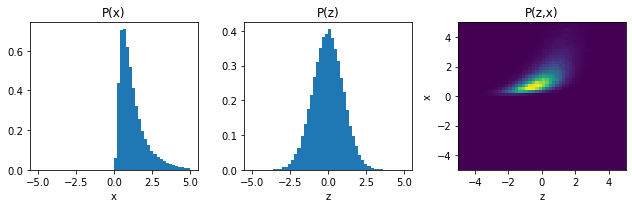

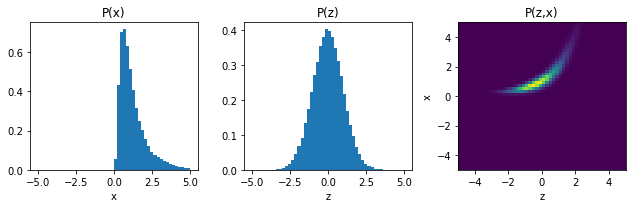

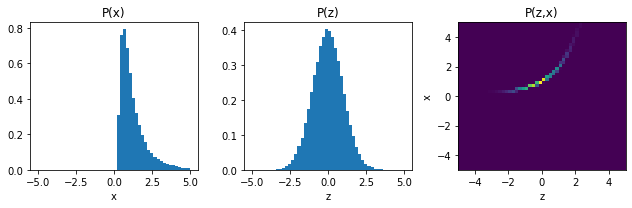

In [221]:
plot_histograms(x,z,50,xy_range=5)
plot_histograms(x_gen, z_gen, 50, xy_range=5)
plot_histograms(x_mean, z_gen, 50, xy_range=5)

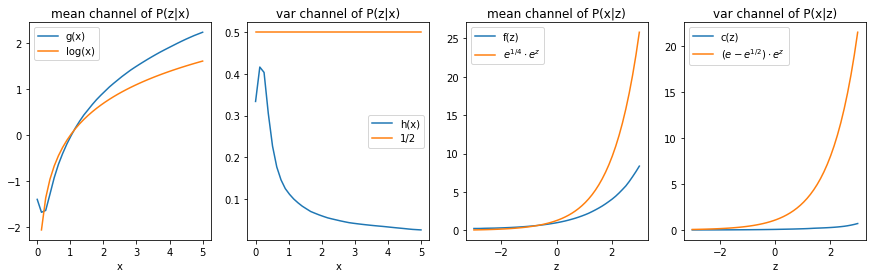

In [222]:
xx = torch.linspace(0,5,40).view(-1,1)
zz = torch.linspace(-3,3,50).view(-1,1)
f_z, c_z, g_x, h_x = net.channels(xx, zz)
fig = plt.figure(figsize=(15,4))
plt.subplot(141)
plt.plot(xx,g_x)
plt.plot(xx,torch.log(xx))
plt.xlabel('x')
plt.title('mean channel of P(z|x)')
plt.legend(('g(x)', 'log(x)'))
plt.subplot(142)
plt.plot(xx,h_x)
plt.plot(xx,0.5 * torch.ones(xx.shape))
plt.xlabel('x')
plt.title('var channel of P(z|x)')
plt.legend(('h(x)','1/2'))
plt.subplot(143)
plt.plot(zz, f_z)
plt.plot(zz, np.exp(1/4) * torch.exp(zz))
plt.xlabel('z')
plt.title('mean channel of P(x|z)')
plt.legend(('f(z)', r'$e^{1/4} \cdot e^z$'))
plt.subplot(144)
plt.plot(zz, c_z)
plt.plot(zz, (np.exp(1) - np.exp(1/2)) * torch.exp(zz))
plt.xlabel('z')
plt.title('var channel of P(x|z)')
plt.legend(('c(z)', r'$(e - e^{1/2}) \cdot e^z$'))